In [ ]:
system = 't2_campus'

In [1]:
# Base library imports
import pandas as pd
import torch
import os
from matplotlib import pyplot as plt

# SolNet imports
from src.data.datafetcher import PvFetcher
from src.data.featurisation import Featurisation
from src.tensors.tensorisation import Tensors
from src.models.lstm import LSTM
from src.models.training import Training
from src.models.training import save_model
from src.evaluation.evaluation import Evaluation

In [2]:
# Hyperparameters needed for a run:

# Data fetching
locations_used = 1
start_date = 2005
end_date = 2018

# Forecasting parameters
target = 'P'
past_features = ['P']
future_features = ['hour_sin','hour_cos']
lags = 24
forecast_period = 24
gap = 0 
forecast_gap = 0

# Lstm parameters
hidden_size = 400
num_layers = 3
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training parameters
epochs = 200
batch_size = 32
learning_rate = 0.0001

## 1. Target location

In [3]:
# EnergyVille and the T2 campus are located almost next to each other, so we keep these coordinates identical for both cases
latitude = 50.995
longitude = 5.539

# Peak power is c. 140 for T2 campus and 320 for EnergyVille
if system == 't2_campus':
    peak_power = 140
else:
    peak_power = 320

In [4]:
# Unique name for the data, model and metrics, change to "energyville" for the second BE case
data_name = "base_" + system
data_name

't2_campus'

In [5]:
# Create the folders to save the data and models
data_folder = '../results/BE/'
model_folder = '../models/BE/' + data_name
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

In [6]:
data_be = pd.read_csv('../data/belgium/' + data_name + '.csv', index_col="Timestamp", parse_dates=True)

In [7]:
# Remove everything up until the first entry starting at midnight
first_index = data_be[(data_be.index.hour == 0) & (data_be.index.day == 1) & (data_be.index.month == 4) & (data_be.index.year == 2019)].index[0]
# Remove everything after the last entry for the final day of december in the data
last_index = data_be[(data_be.index.hour == 23) & (data_be.index.year == 2020)].index[-1]
data_be = data_be.loc[first_index:last_index]

target_data = data_be

## 2. Source location

In [8]:
# Fetch data from PVGIS
data_PVGIS = PvFetcher(latitude,longitude,peak_power, 0, 0, locations=locations_used, start_date=start_date, end_date=end_date,optimal_angles=1)

Gathering data from base location...


In [9]:
# No localization needed for BE data
data = [data_PVGIS.dataset[0]]

# 3. Featurisation

## 3.1 Source

Cyclical features

In [10]:
# Decide on the features to use in making the model (Note that 'P' should always be included since it's the target variable)
dataset = Featurisation(data).base_features(past_features)

# Include cyclical features
dataset = Featurisation(dataset).cyclic_features(yearly=False)
features = dataset[0].columns # update the features
source_data = dataset[0].copy()

## 3.2 Target

Cyclical features

In [11]:
# Identical to the source domain
target_featurisation = Featurisation([target_data])
target_data = target_featurisation.cyclic_features()[0]

In [12]:
# Include domain knowledge into the target domain for scaling purposes
# We know that the minimum power is always 0
domain_min = [0.0]
# We are going to assume that the maximum is the peak rated power times some degradation factor. In the paper we assume this degradation is 14%, this is the number also used by PVGIS
# cf. https://joint-research-centre.ec.europa.eu/photovoltaic-geographical-information-system-pvgis/getting-started-pvgis/pvgis-user-manual_en#ref-9-hourly-solar-radiation-and-pv-data
domain_max = [peak_power*0.86]

# For other features we just assume that the minimum and maximum are what we have seen in the source data, this data is freely available, so this is not a stretch
other_features = past_features[1:] + future_features

for i in range(len(other_features)):
    domain_min.append(min(source_data[other_features[i]]))
    domain_max.append(max(source_data[other_features[i]]))

# 4. Tensors

## 4.1 Source

In [13]:
# Get the data in the torch.tensor format
src_tensors = Tensors(source_data, 'P', past_features , future_features, lags, forecast_period, gap=gap, forecast_gap=forecast_gap)

# Split the data into train and test sets with separate tensors for features (X) and the target (y)
X_train_src, X_test_src, y_train_src, y_test_src = src_tensors.create_tensor()
X_train_src.shape, X_test_src.shape, y_train_src.shape, y_test_src.shape

(torch.Size([4090, 24, 3]),
 torch.Size([1022, 24, 3]),
 torch.Size([4090, 24]),
 torch.Size([1022, 24]))

## 4.2 Target

For the target dataset we require a separate "evaluation set" of a full year, apart from the train and test set. This makes the tensorisation of the data a bit more complex than what we did for the source domain.

In [14]:
# Take apart the train and test data
target_excl_eval = target_data[:-366*24]

In [15]:
# Get the months we have available for training. We need this info to make separate cases for each unique case of having "X months" of data in the target domain
training_months = list(target_excl_eval.index.month.unique())

In [16]:
# the timestamps of the training start points for each case of having "X months" of data
train_starts = []
for i in range(len(training_months)):
    train_start = target_excl_eval[(target_excl_eval.index.month ==training_months[i])].index[0]
    train_starts.append(train_start)
    
train_starts = list(reversed(train_starts))

In [17]:
# Get the target data in lists holding all the tensors for each of the "X months" cases. This time with a train and test set, as well as a separate evaluation set. 
X_train_target_list = []
X_test_target_list = []
X_eval_target_list = []
y_train_target_list = []
y_test_target_list = []
y_eval_target_list = []

for i in range(len(training_months)):
    tgt_tensors = Tensors(target_data.loc[train_starts[i]:], 'P', past_features , future_features, lags, forecast_period, gap=gap, forecast_gap=forecast_gap, evaluation_length=24*365, domain_min=domain_min, domain_max=domain_max)
    X_train_tgt, X_test_tgt, X_eval_tgt, y_train_tgt, y_test_tgt, y_eval_tgt = tgt_tensors.create_tensor()
    X_train_target_list.append(X_train_tgt)
    X_test_target_list.append(X_test_tgt)
    X_eval_target_list.append(X_eval_tgt)
    y_train_target_list.append(y_train_tgt)
    y_test_target_list.append(y_test_tgt)
    y_eval_target_list.append(y_eval_tgt) 
    print(X_train_tgt.shape, X_test_tgt.shape, X_eval_tgt.shape, y_train_tgt.shape, y_test_tgt.shape, y_eval_tgt.shape)

torch.Size([25, 24, 3]) torch.Size([6, 24, 3]) torch.Size([364, 24, 3]) torch.Size([25, 24]) torch.Size([6, 24]) torch.Size([364, 24])
torch.Size([49, 24, 3]) torch.Size([12, 24, 3]) torch.Size([364, 24, 3]) torch.Size([49, 24]) torch.Size([12, 24]) torch.Size([364, 24])
torch.Size([74, 24, 3]) torch.Size([18, 24, 3]) torch.Size([364, 24, 3]) torch.Size([74, 24]) torch.Size([18, 24]) torch.Size([364, 24])
torch.Size([98, 24, 3]) torch.Size([24, 24, 3]) torch.Size([364, 24, 3]) torch.Size([98, 24]) torch.Size([24, 24]) torch.Size([364, 24])
torch.Size([122, 24, 3]) torch.Size([31, 24, 3]) torch.Size([364, 24, 3]) torch.Size([122, 24]) torch.Size([31, 24]) torch.Size([364, 24])
torch.Size([147, 24, 3]) torch.Size([37, 24, 3]) torch.Size([364, 24, 3]) torch.Size([147, 24]) torch.Size([37, 24]) torch.Size([364, 24])
torch.Size([171, 24, 3]) torch.Size([43, 24, 3]) torch.Size([364, 24, 3]) torch.Size([171, 24]) torch.Size([43, 24]) torch.Size([364, 24])
torch.Size([196, 24, 3]) torch.Size([

# 5. Source model

In [18]:
# Set the parameters for the lstm
input_size = len(past_features + future_features)

my_lstm = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
my_lstm

LSTM(
  (lstm): LSTM(3, 400, num_layers=3, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=400, out_features=24, bias=True)
)

In [19]:
# Initialize the trainer
training = Training(my_lstm, X_train_src, y_train_src, X_test_src, y_test_src, epochs,batch_size=batch_size, learning_rate=learning_rate)

# Train the model and return the trained parameters and the best iteration
state_dict_list, best_epoch = training.fit()

Step 0: Average train loss: 0.0308 | Average test loss: 0.0232
Step 5: Average train loss: 0.0192 | Average test loss: 0.0180
Step 10: Average train loss: 0.0190 | Average test loss: 0.0178
Step 15: Average train loss: 0.0189 | Average test loss: 0.0177
Step 20: Average train loss: 0.0187 | Average test loss: 0.0176
Step 25: Average train loss: 0.0185 | Average test loss: 0.0177
Step 30: Average train loss: 0.0182 | Average test loss: 0.0176
Step 35: Average train loss: 0.0178 | Average test loss: 0.0169
Step 40: Average train loss: 0.0177 | Average test loss: 0.0167
Step 45: Average train loss: 0.0176 | Average test loss: 0.0167
Step 50: Average train loss: 0.0175 | Average test loss: 0.0166
Step 55: Average train loss: 0.0175 | Average test loss: 0.0166
Step 60: Average train loss: 0.0175 | Average test loss: 0.0165
Step 65: Average train loss: 0.0174 | Average test loss: 0.0166
Step 70: Average train loss: 0.0174 | Average test loss: 0.0165
Step 75: Average train loss: 0.0174 | Aver

In [20]:
# Load the state dictionary of the best performing model
my_lstm.load_state_dict(state_dict_list[best_epoch])

# Save the model state dictionary for later use 
save_model(my_lstm, 'BE/' + data_name + '/model_' + data_name + '_transfer_0')

In [21]:
# Forecast with the model
forecasts = my_lstm(X_test_src.to(device))

# Evaluate the model performance
source_eval = Evaluation(y_test_src.detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

# 6. Target model

In [22]:
# Set the parameters for the lstm
input_size = len(past_features + future_features)

# Create empty models for each of the periods
target_lstm_list = []

for i in range(len(training_months)+1):
    target_lstm_list.append(LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device))
    
torch.save(target_lstm_list[0].state_dict(), '../models/BE/' + data_name + '/model_' + data_name + '_target_0')

In [23]:
target_best_epochs = [0]

for i in range(len(training_months)):
    # Initialize the trainer
    training = Training(target_lstm_list[i+1], X_train_target_list[i], y_train_target_list[i], X_test_target_list[i], y_test_target_list[i], epochs, learning_rate=learning_rate)

    # Train the model and return the trained parameters and the best iteration
    state_dict_list, best_epoch = training.fit()
    
    # Load the state dictionary of the best performing model
    target_lstm_list[i+1].load_state_dict(state_dict_list[best_epoch])
    target_best_epochs.append(best_epoch)

Step 0: Average train loss: 0.0044 | Average test loss: 0.0062
Step 5: Average train loss: 0.0029 | Average test loss: 0.0044
Step 10: Average train loss: 0.0017 | Average test loss: 0.0028
Step 15: Average train loss: 0.0009 | Average test loss: 0.0015
Step 20: Average train loss: 0.0010 | Average test loss: 0.0011
Step 25: Average train loss: 0.0009 | Average test loss: 0.0012
Step 30: Average train loss: 0.0008 | Average test loss: 0.0014
Step 35: Average train loss: 0.0008 | Average test loss: 0.0015
Step 40: Average train loss: 0.0008 | Average test loss: 0.0014
Step 45: Average train loss: 0.0008 | Average test loss: 0.0013
Step 50: Average train loss: 0.0008 | Average test loss: 0.0013
Step 55: Average train loss: 0.0008 | Average test loss: 0.0013
Step 60: Average train loss: 0.0008 | Average test loss: 0.0013
Step 65: Average train loss: 0.0008 | Average test loss: 0.0013
Step 70: Average train loss: 0.0008 | Average test loss: 0.0013
Step 75: Average train loss: 0.0008 | Aver

In [24]:
target_RMSEs = []
target_MBEs = []
target_MAEs = []

# Evaluate a clean model
forecasts = target_lstm_list[0](X_eval_target_list[0].to(device))
source_eval = Evaluation(y_eval_target_list[0].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

target_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
target_MBEs.append(source_eval.metrics()['MBE'].values[0])
target_MAEs.append(source_eval.metrics()['MAE'].values[0])

for i in range(len(training_months)):
    # Forecast with the model
    forecasts = target_lstm_list[i+1](X_eval_target_list[i].to(device))
    # Evaluate the model performance
    source_eval = Evaluation(y_eval_target_list[i].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

    # Show the evaluation metrics
    target_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
    target_MBEs.append(source_eval.metrics()['MBE'].values[0])
    target_MAEs.append(source_eval.metrics()['MAE'].values[0])

# 7. Transfer model

In [25]:
# Layers to freeze

freezing = []

for name, _ in my_lstm.lstm.named_parameters():
    freezing.append(name)
    
freezing = freezing[:4]
freezing

['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0']

In [27]:
transfer_models = []
transfer_best_epochs = [0]

for i in range(len(training_months)):
    transfer_model  = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
    transfer_model.load_state_dict(torch.load('../models/BE/' + data_name + '/model_' + data_name + '_transfer_0'))
       
    for name, param in transfer_model.lstm.named_parameters():
        if any(freezing_name in name for freezing_name in freezing):
            param.requires_grad = False

    # Initialize the trainer
    training = Training(transfer_model, 
                              X_train_target_list[i], y_train_target_list[i], X_test_target_list[i], y_test_target_list[i], 
                              epochs=1000, batch_size = batch_size, learning_rate =learning_rate/100)

    # Train the model and return the trained parameters and the best iteration
    state_dict_list, best_epoch = training.fit()
    
    # Load the state dictionary of the best performing model
    transfer_model.load_state_dict(state_dict_list[best_epoch])
    
    transfer_best_epochs.append(best_epoch)
    transfer_models.append(transfer_model)

Step 0: Average train loss: 0.0038 | Average test loss: 0.0030
Step 5: Average train loss: 0.0036 | Average test loss: 0.0029
Step 10: Average train loss: 0.0039 | Average test loss: 0.0029
Step 15: Average train loss: 0.0036 | Average test loss: 0.0029
Step 20: Average train loss: 0.0036 | Average test loss: 0.0029
Step 25: Average train loss: 0.0034 | Average test loss: 0.0028
Step 30: Average train loss: 0.0033 | Average test loss: 0.0028
Step 35: Average train loss: 0.0034 | Average test loss: 0.0028
Step 40: Average train loss: 0.0033 | Average test loss: 0.0027
Step 45: Average train loss: 0.0034 | Average test loss: 0.0027
Step 50: Average train loss: 0.0033 | Average test loss: 0.0027
Step 55: Average train loss: 0.0033 | Average test loss: 0.0026
Step 60: Average train loss: 0.0035 | Average test loss: 0.0026
Step 65: Average train loss: 0.0032 | Average test loss: 0.0026
Step 70: Average train loss: 0.0035 | Average test loss: 0.0026
Step 75: Average train loss: 0.0032 | Aver

In [28]:
transfer_RMSEs = []
transfer_MBEs = []
transfer_MAEs = []

# Evaluate a clean model

transfer_model = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
transfer_model.load_state_dict(torch.load('../models/BE/' + data_name + '/model_' + data_name + '_transfer_0'))

forecasts = transfer_model(X_eval_target_list[0].to(device))
source_eval = Evaluation(y_eval_target_list[0].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

transfer_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
transfer_MBEs.append(source_eval.metrics()['MBE'].values[0])
transfer_MAEs.append(source_eval.metrics()['MAE'].values[0])

for i in range(len(training_months)):
    # Forecast with the model
    forecasts = transfer_models[i](X_eval_target_list[i].to(device))
    # Evaluate the model performance
    source_eval = Evaluation(y_eval_target_list[i].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

    # Show the evaluation metrics
    transfer_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
    transfer_MBEs.append(source_eval.metrics()['MBE'].values[0])
    transfer_MAEs.append(source_eval.metrics()['MAE'].values[0])

# 8. Baseline

In [31]:
baseline_RMSEs = []
baseline_MBEs = []
baseline_MAEs = []

# Evaluate a clean model, our forecast in this case is basically the first feature in our features tensor, as we predict the next day to be the previous one 
forecasts = X_eval_target_list[0][:,:,0]
source_eval = Evaluation(y_eval_target_list[0].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

baseline_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
baseline_MBEs.append(source_eval.metrics()['MBE'].values[0])
baseline_MAEs.append(source_eval.metrics()['MAE'].values[0])

for i in range(len(training_months)):
    # Forecast with the model
    forecasts = X_eval_target_list[i][:,:,0]
    forecasts_np = forecasts.cpu().detach().flatten().numpy()
    forecasts_np[forecasts_np < 0] = 0
    # Evaluate the model performance
    source_eval = Evaluation(y_eval_target_list[i].detach().flatten().numpy(), forecasts_np)

    # Show the evaluation metrics
    baseline_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
    baseline_MBEs.append(source_eval.metrics()['MBE'].values[0])
    baseline_MAEs.append(source_eval.metrics()['MAE'].values[0])

# 9. Final visualisation and export

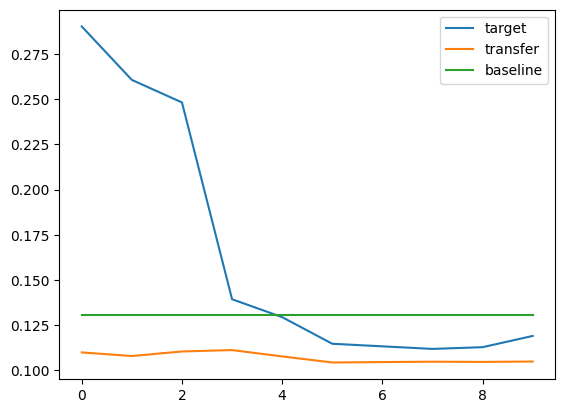

In [32]:
plt.plot(target_RMSEs,label='target')
plt.plot(transfer_RMSEs,label='transfer')
plt.plot(baseline_RMSEs, label='baseline')
plt.legend()

In [33]:
column_names = []

for i in range(len(training_months)+1):
    column_names.append(str(i) + 'm')

In [34]:
all_metrics = pd.DataFrame([baseline_RMSEs, target_RMSEs, transfer_RMSEs,
                            baseline_MBEs, target_MBEs, transfer_MBEs,
                            baseline_MAEs, target_MAEs, transfer_MAEs, 
                            target_best_epochs, transfer_best_epochs],
                           columns=column_names, index=['Baseline RMSE', 'Target RMSE', 'Transfer RMSE', 
                                                        'Baseline MBE', 'Target MBE', 'Transfer MBE', 
                                                        'Baseline MAE', 'Target MAE', 'Transfer MAE', 
                                                        'Target epoch', 'Transfer epoch']).transpose()

all_metrics['Target epoch'] = all_metrics['Target epoch'].astype(int)
all_metrics['Transfer epoch'] = all_metrics['Transfer epoch'].astype(int)
all_metrics

,Baseline RMSE,Target RMSE,Transfer RMSE,Baseline MBE,Target MBE,Transfer MBE,Baseline MAE,Target MAE,Transfer MAE,Target epoch,Transfer epoch
0m,0.131,0.290,0.110,-0.000,0.141,0.006,0.057,0.158,0.059,0,0
1m,0.131,0.261,0.108,-0.000,0.128,0.015,0.057,0.131,0.056,21,626
2m,0.131,0.248,0.110,-0.000,0.118,0.020,0.057,0.124,0.056,8,982
3m,0.131,0.139,0.111,-0.000,0.043,0.022,0.057,0.074,0.057,5,999
4m,0.131,0.129,0.108,-0.000,0.036,0.015,0.057,0.069,0.055,97,364
5m,0.131,0.115,0.104,-0.000,0.010,0.003,0.057,0.060,0.053,3,546
6m,0.131,0.113,0.105,-0.000,0.001,0.003,0.057,0.060,0.053,2,865
7m,0.131,0.112,0.105,-0.000,-0.001,0.002,0.057,0.060,0.053,186,566
8m,0.131,0.113,0.105,-0.000,-0.003,0.004,0.057,0.061,0.053,193,825
9m,0.131,0.119,0.105,-0.000,-0.023,0.001,0.057,0.069,0.054,1,998


In [35]:
all_metrics.to_csv('../results/BE/' + 'summary_table_' + data_name + '.csv')

In [36]:
data_name

't2_campus'